# Ackley 1d toy exaples

In [1]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from rebayes_mini.methods import gauss_filter
from rebayes_mini.methods import base_filter
from rebayes_mini.methods import low_rank_filter as lofi

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [5]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def ackley_1d(x, y=0):
    out = (-20*jnp.exp(-0.2*jnp.sqrt(0.5*(x**2 + y**2))) 
           - jnp.exp(0.5*(jnp.cos(2*jnp.pi*x) + jnp.cos(2*jnp.pi*y)))
           + jnp.e + 20)
    
    return out

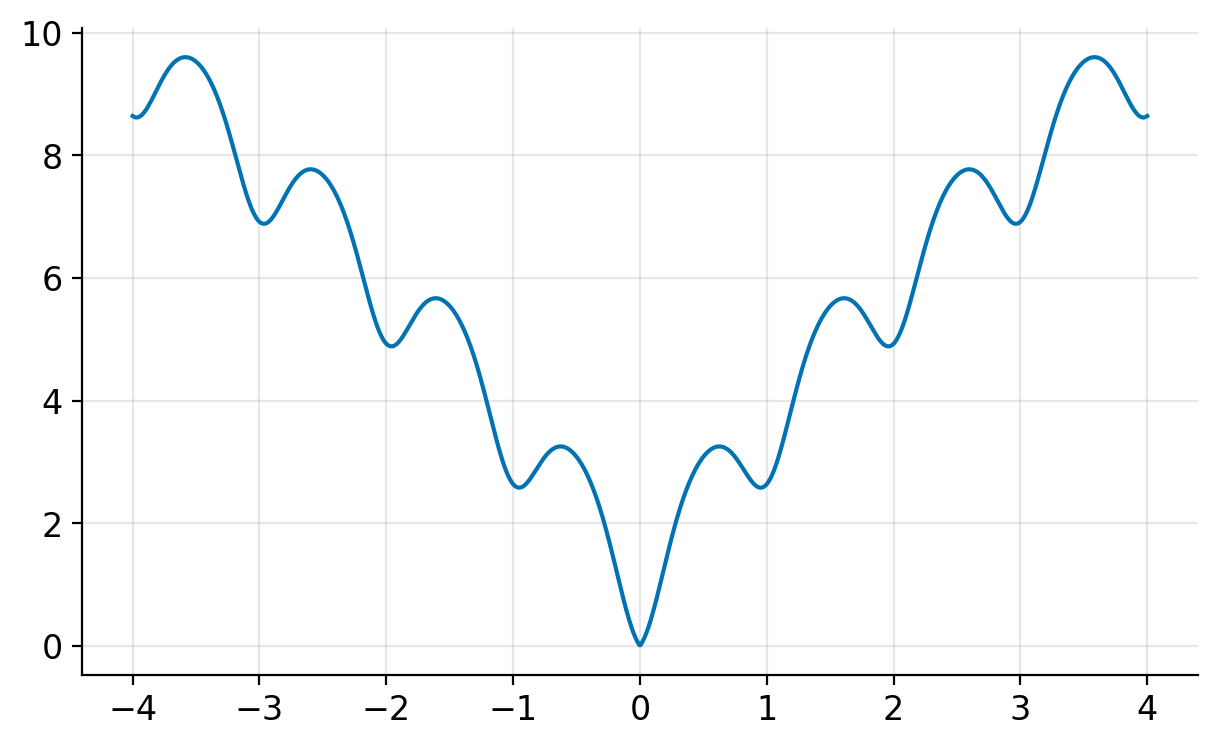

In [7]:
xrange = jnp.linspace(-4, 4, 1000)
yvals = ackley_1d(xrange)
ymean = yvals.mean()
ystd = yvals.std()
# yvals = (yvals - ymean) / ystd

plt.plot(xrange, yvals)
plt.grid(alpha=0.3)

## The BNN surrogate model

In [40]:
class MLP(nn.Module):
    n_hidden: int = 20

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = jnp.sin(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [55]:
key = jax.random.PRNGKey(314)
key_data, key_train, key_sample = jax.random.split(key, 3)

## Training model

In [56]:
n_obs = 15
x_samples = jax.random.uniform(key_data, shape=(n_obs,1), minval=-4, maxval=4)

In [57]:
y_samples = ackley_1d(x_samples)
# y_samples = (y_samples - ymean) / ystd

In [58]:
def callback(bel_update, bel_pred, y, x, agent):
    Ht = agent.grad_mean(bel_update.mean, x)
    yhat = agent.mean_fn(bel_update.mean, x).astype(float)
    err = y - yhat - Ht @ (bel_pred.mean - bel_update.mean)
    return jnp.abs(err)

In [203]:
qlow, qhigh = 0.95, 0.05

## Full-covariance EKF

In [204]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0, n_inner=1)
bel_init = agent.init_bel(params_init, cov=0.1 ** 2)

bel, hist = agent.scan(bel_init, y_samples, x_samples, callback)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 17.5 s, sys: 260 ms, total: 17.8 s
Wall time: 2.5 s


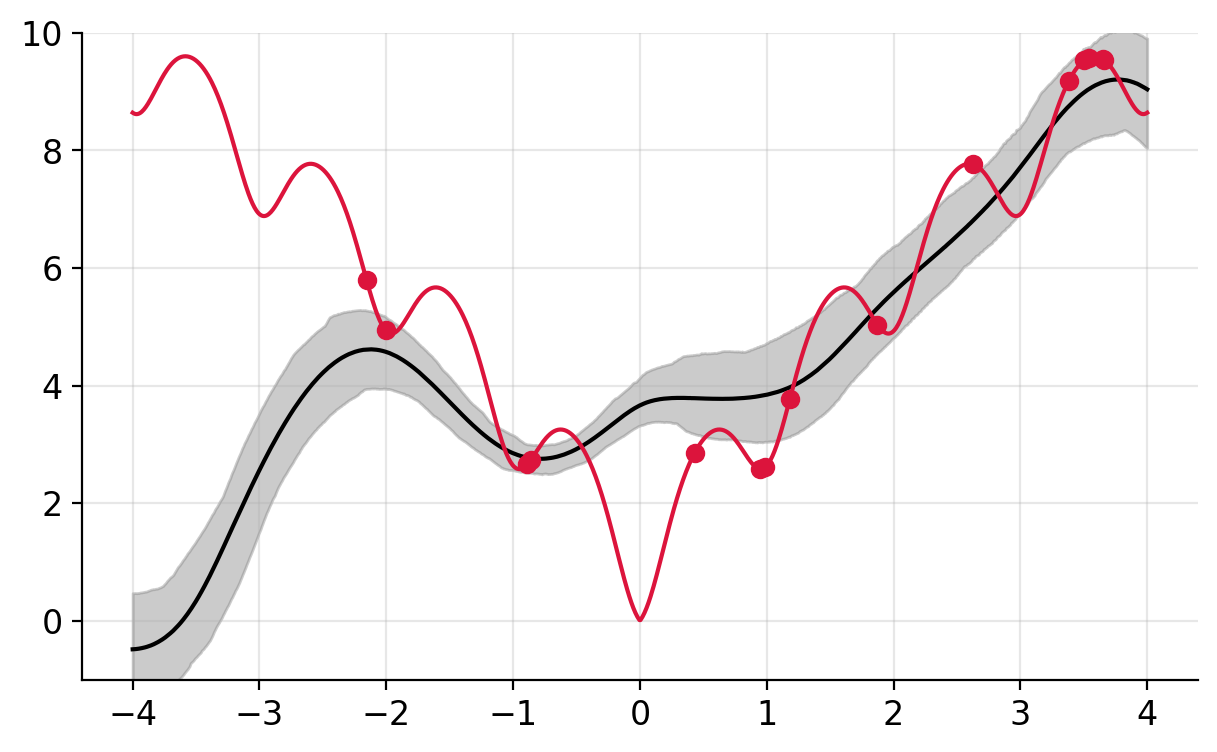

In [205]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

sample_params = jnp.einsum("ji,sj->si", bel.W, eps) + bel.mean

eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, eval_samples.mean(axis=0), c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## LoFi
* $R_t$ cannot be set to zero

In [210]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

agent = lofi.GaussianFilter(model.apply, dynamics_covariance=1e-7, variance=0.01, rank=20)
bel_init = agent.init_bel(params_init, cov=0.1 ** 2)

bel, hist = agent.scan(bel_init, y_samples, x_samples)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 2.17 s, sys: 68.2 ms, total: 2.24 s
Wall time: 1 s


In [211]:
@partial(jax.vmap, in_axes=(0, None))
def sample_lofi_params(key, bel):
    return agent._sample_lr_params(key, bel)

In [212]:
keys_samples = jax.random.split(key_sample, 100)
sample_params = sample_lofi_params(keys_samples, bel)

In [213]:
eval_samples = jax.vmap(agent.link_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

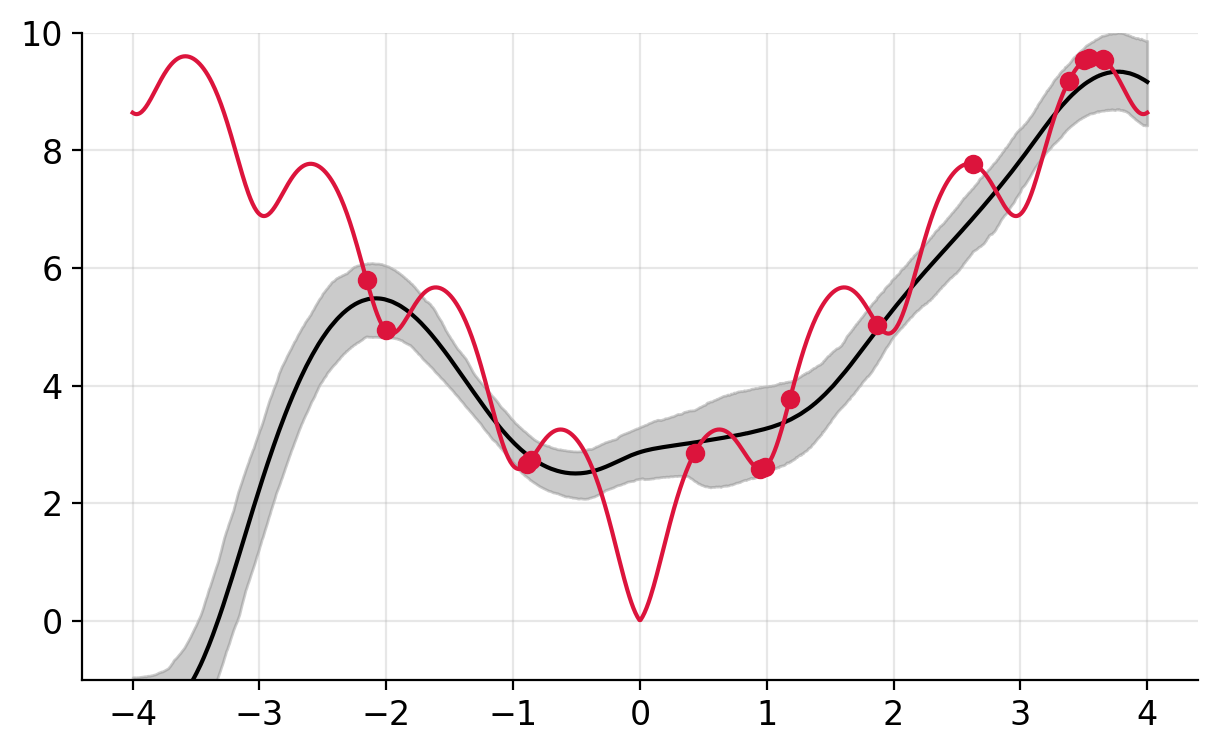

In [214]:
lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.4)
plt.plot(xrange, eval_samples.mean(axis=0), c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Full-covariance ll-lr aware EKF

In [215]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples)

def cov_fn(y): return 0.0
agent = base_filter.SquareRootFilter(model.apply, cov_fn, dynamics_covariance=0.0, n_inner=1)
bel_init = agent.init_bel(params_init, cov=0.0005 ** 2)

# replacing last-layer covariance
bel_init = bel_init.replace(W=bel_init.W.at[-21:, -21:].set(jnp.eye(21) * 10.0))

bel, hist = agent.scan(bel_init, y_samples, x_samples, callback)
hist = jax.tree.map(np.array, hist)
bel = jax.block_until_ready(bel)

CPU times: user 17.6 s, sys: 702 ms, total: 18.3 s
Wall time: 2.66 s


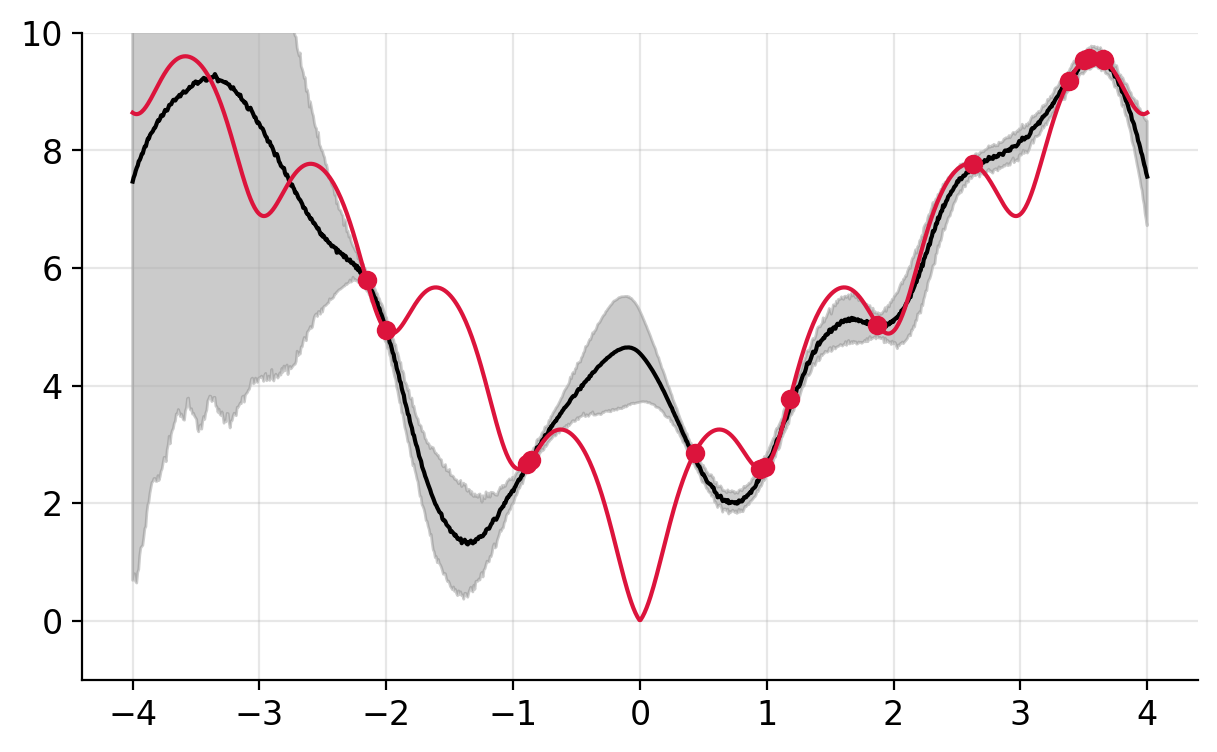

In [216]:
eps = jax.random.normal(key_sample, (100, len(bel.mean)))

sample_params = jnp.einsum("ji,sj->si", bel.W, eps) + bel.mean

eval_samples = jax.vmap(agent.mean_fn, in_axes=(0, None))(sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

# plt.plot(xrange, eval_samples.T, c="tab:gray", alpha=0.3)
plt.plot(xrange, eval_samples.mean(axis=0), c="black")
plt.plot(xrange, yvals, c="crimson")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)

## Gaussian process

In [217]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def matern_kernel(u, v, length_scale=1.0, nu=2.5):
    # Compute the distance between u and v
    r = jnp.abs(u - v)

    # Calculate the scaling factor
    scaled_distance = jnp.sqrt(2 * nu) * r / length_scale

    # Define the Matérn kernel based on the value of nu
    if nu == 1.5:
        kernel_value = (1 + scaled_distance) * jnp.exp(-scaled_distance)
    elif nu == 2.5:
        kernel_value = (1 + scaled_distance + scaled_distance**2 / 3) * jnp.exp(-scaled_distance)
    else:
        raise ValueError(f"Unsupported nu value: {nu}")

    return kernel_value

In [218]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def kgauss(u, v, gamma2=1.0):
    return jnp.exp(-(u - v) ** 2 / (2 * gamma2))

kgauss = matern_kernel
sigma = 0.5
x = x_samples.squeeze()
# Estimate variance and covariances
var_train = kgauss(x, x, sigma)
cov_test_train = kgauss(xrange, x, sigma)
var_test = kgauss(xrange, xrange, sigma)

# Make predictions
K = jnp.linalg.solve(var_train, cov_test_train.T).T
mu_pred = K @ y_samples
sigma_pred = var_test - K @ var_train @ K.T
sigma_pred = jnp.diag(sigma_pred)

In [219]:
ubound = mu_pred.squeeze() + 2 * sigma_pred
lbound = mu_pred.squeeze() - 2 * sigma_pred

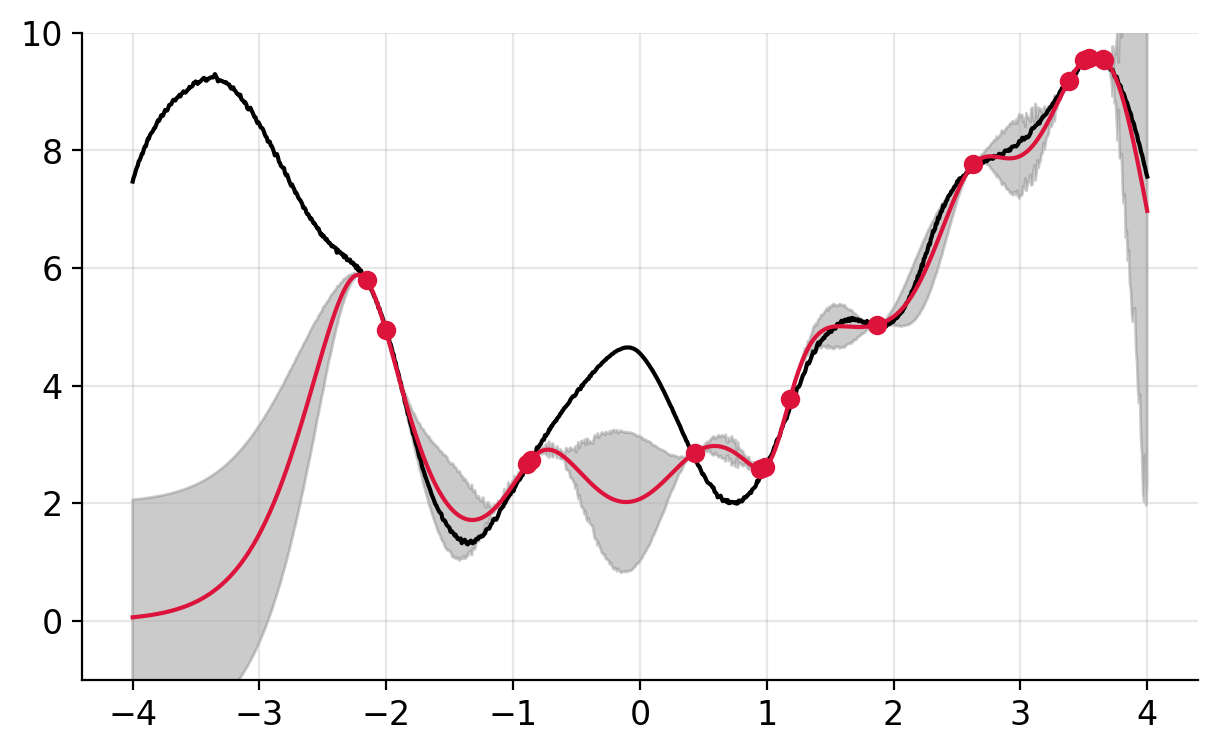

In [220]:
plt.plot(xrange, eval_samples.mean(axis=0), c="black")
plt.plot(xrange, mu_pred, c="crimson")
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)
plt.scatter(x_samples, y_samples, c="crimson", zorder=3)
plt.ylim(-1, 10)
plt.grid(alpha=0.3)